In [1]:
import cv2
import numpy as np
import glob
import seaborn as sns
import math
from sklearn.ensemble import IsolationForest
from matplotlib import pyplot as plt

In [2]:
SIFT_method = True

Questa funzione prende in ingresso l'immagine originale, l'immagine ritagliata e il nome del salvataggio. Restituisce un immagine che rappresenta la zona di lavoro

In [3]:
def cutWorkSpace(img,border): 
    # dimensioni immagini
    img_h = 2048
    img_l = 2048
    # offset per posizionamento su area d'indagine
    offset_x = 600
    offset_y = 500
    
    #taglio per garantire la ricerca sull'area di interesse, evitando rumori dati dallo sfondo
    crop_img = img[offset_y:img_h-offset_y, offset_x:img_l-offset_x]
    
    # Convert the img to grayscale
    gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #cv2.imwrite('provaT.jpg', thresh_im)
    lowThresh = 0.5*high_thresh
    
    
    # Apply edge detection method on the image
    #edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    #cv2.imwrite('results_img/'+str(count_img)+'ed.jpg', edges)
    #cv2.imwrite('canny.jpg', edges)
    # This returns an array of r and theta values
    lines = cv2.HoughLines(edges,1,np.pi/180, 100)
    #cv2.imwrite('Risultati/resFS'+name+'c.jpg', edges)
    # The below for loop runs till r and theta values 
    # are in the range of the 2d array
    i = 0
    x_first = 0
    x_second = 0
    count = 0
    delta = 30
    thetaFinal = 0
    while count < 2:
        for r,theta in lines[i]:
            # Stores the value of cos(theta) in a
            a = np.cos(theta)

            # Stores the value of sin(theta) in b
            b = np.sin(theta)

            # x0 stores the value rcos(theta)
            x0 = a*r

            # y0 stores the value rsin(theta)
            y0 = b*r

            #ti define line lenght
            const = 3000
            # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
            x1 = int(x0 + const*(-b))

            # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
            y1 = int(y0 + const*(a))

            # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
            x2 = int(x0 - const*(-b))

            # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
            y2 = int(y0 - const*(a))

            if count == 0 :
                if theta != 0:
                    thetaFinal = 180-math.degrees(theta)
                x_first = x0
                #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                count += 1
            else:
                if abs(x_first-x0) > delta :
                    x_second = x0
                    #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                    count += 1
            i += 1
    # All the changes made in the input image are finally
    # written on a new image houghlines.jpg
    #cv2.imwrite('Risultati/res'+name+'.jpg', img)
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # rotate our image by Theta degrees around the center of the image
    M = cv2.getRotationMatrix2D((cX, cY), -thetaFinal, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    scale_percent = 100 # percent of original size

  
    if x_first < x_second:
        
        median = (x_second+x_first)//2
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)        
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    else:
        median = (x_first+x_second)//2.
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]        
        #blurred = cv2.GaussianBlur(temp, (3,3), 0)
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    

In [4]:
def divideImage(img,pcs):
    results = []
    lung = len(img) // pcs
    for i in range(pcs):
        results.append(img[(lung*i):(lung*(i+1)-1)][:])

    return results

## Creazione histogramma usando features - creazione NN
accetta in ingresso un vettore con [[img],[classe]]
in uscita mi ritorna kmeans e MLP

In [5]:
keypoints_fixed = []
x1 = 60
y1 = 60

x2 = 80
y2 = 40

x3 = 40
y3 = 40

x4 = 40
y4= 80

x5 = 80
y5 = 80

size = 75

angle = 0

square_size =120
for i in range (17):
    # rappresenta X, Y, size diametro, angle, response, octave, class id
    keypoints_fixed.append(cv2.KeyPoint(x1,y1+i*square_size,size, angle, 0, 0, -1 ))
    keypoints_fixed.append(cv2.KeyPoint(x2,y2+i*square_size,size, angle, 0, 0, -1 ))
    keypoints_fixed.append(cv2.KeyPoint(x3,y3+i*square_size,size, angle, 0, 0, -1 ))
    keypoints_fixed.append(cv2.KeyPoint(x4,y4+i*square_size,size, angle, 0, 0, -1 ))
    keypoints_fixed.append(cv2.KeyPoint(x5,y5+i*square_size,size, angle, 0, 0, -1 ))



In [6]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier

def createNN(imgsWithClass, Nclusters):
    if SIFT_method:
        sift = cv2.xfeatures2d.SIFT_create()
    else:
        orb = cv2.ORB_create()   
    results = imgsWithClass[0]

    keypoints = []
    descriptors = []
    dico = []
    for img in results:
        if SIFT_method:
            keypoints_temp = keypoints_fixed
            keypoints_temp, descriptors_temp = sift.compute(img, keypoints_temp)
        else:    
            keypoints_temp, descriptors_temp = orb.detectAndCompute(img, None)
        keypoints.append(keypoints_temp)
        descriptors.append(descriptors_temp)
        for d in descriptors_temp:
            dico.append(d)        
    k = Nclusters
    batch_size = 256*4
    print(k)
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=1).fit(dico)
    
    length = len(results)

    train_index = length - 1 
    train_imgs = results[:train_index]
    validation_imgs = results[train_index:]
    
    # creo histogramma con valori trovati di feature per ogni immagine di train
    kmeans.verbose = False
    histo_list = []

    for img in train_imgs:
        if SIFT_method:
            kp = keypoints_fixed
            kp,des = sift.compute(img, kp)
        else:
            kp, des = orb.detectAndCompute(img,None)
        histo = np.zeros(k)
        nkp = np.size(kp)

        for d in des:
            idx = kmeans.predict([d])
            histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

        histo_list.append(histo)
    #creo X_train e Y_train
    X_train = np.array(histo_list)  
    Y_train = imgsWithClass[1][:train_index]
    
    
    return histo_list,kmeans
    #return kmeans, mlp, val_result

Creo funzione per testare immagini sulla NN trovata

In [20]:
def testNN(img_test,border,pcs,Nclusters):
    img = cutWorkSpace(img_test,border)
    imgs = divideImage(img,pcs)
    if SIFT_method:
        sift = cv2.xfeatures2d.SIFT_create(nfeatures)
    else:
        orb = cv2.ORB_create()   

    k = Nclusters
    results = []
    for img in imgs:
        if SIFT_method:
            kp = keypoints_fixed
            kp, des = sift.compute(img, kp)
        else:
            kp, des = orb.detectAndCompute(img,None)
            
        x = np.zeros(k)
        nkp = np.size(kp)
        for d in des:
            idx = kmeans.predict([d])
            x[idx] += 1/nkp #ottengo vettore normalizzato da kmeans
        t = []
        t.append(x)
        results.append(model.predict(t))

        
    return results

In [40]:
scelta = 120

if scelta == 70:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni70/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni70Val/*.tif'
    contamination_N = 6/79.

if scelta == 100:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni100/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni100Val/*.tif'
    contamination_N = 6/107.
if scelta == 120:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120Val/*.tif'
    contamination_N = 6/126.

pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'

pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'

pezziXimmagine = 1
border = 60
Nclusters = 30
nfeatures = 100
#
#


results = []
img_results = []
list_paths = []

list_paths += glob.glob(pathScarti)
results += [1] * len(glob.glob(pathScarti)) * pezziXimmagine

list_paths += glob.glob(pathBuoni) 
results += [0] * len(glob.glob(pathBuoni)) * pezziXimmagine

#list_paths += glob.glob(pathFS)
#results += [0] * len(glob.glob(pathFS)) * pezziXimmagine


#list_paths += glob.glob(pathBuoniVal) 
#results += [0] * len(glob.glob(pathBuoniVal)) * pezziXimmagine

#list_paths += glob.glob(pathFSVal)
#results += [0] * len(glob.glob(pathFSVal)) * pezziXimmagine

#list_paths += glob.glob(pathScartiVal)
#results += [1] * len(glob.glob(pathScartiVal)) * pezziXimmagine



#print(results)
i = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    #cv2.imwrite('ImgScarte/img'+str(i)+'.jpg', temp)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results += temp2
    j = 0
    for im in temp2:
        #cv2.imwrite('ImgScarte/img'+str(i)+'pzs'+str(j)+'.jpg', im)
        j += 1
    i += 1

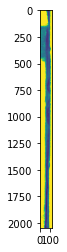

In [41]:
plt.imshow(img_results[0])
plt.show()

In [42]:
imgsWithClass = [img_results,results]


histo,kmeans = createNN(imgsWithClass, Nclusters)

30
Init 1/3 with method: k-means++
Inertia for init 1/3: 13679677.251849
Init 2/3 with method: k-means++
Inertia for init 2/3: 13670620.587073
Init 3/3 with method: k-means++
Inertia for init 3/3: 13673883.088429
Minibatch iteration 1/1100: mean batch inertia: 4479.314088, ewa inertia: 4479.314088 
Minibatch iteration 2/1100: mean batch inertia: 4439.080221, ewa inertia: 4471.559622 
Minibatch iteration 3/1100: mean batch inertia: 4627.030293, ewa inertia: 4501.524231 
Minibatch iteration 4/1100: mean batch inertia: 4207.438064, ewa inertia: 4444.843592 
Minibatch iteration 5/1100: mean batch inertia: 4352.049125, ewa inertia: 4426.958869 
Minibatch iteration 6/1100: mean batch inertia: 4353.267481, ewa inertia: 4412.755974 
Minibatch iteration 7/1100: mean batch inertia: 4708.485123, ewa inertia: 4469.753273 
Minibatch iteration 8/1100: mean batch inertia: 4594.778161, ewa inertia: 4493.849920 
Minibatch iteration 9/1100: mean batch inertia: 4488.587733, ewa inertia: 4492.835713 
Mini

In [43]:
import pandas as pd

print(Nclusters)
cols = []
hist_2 = []
i = 0
for h in histo:
    temp = []
    temp.append(list_paths[i])
    for el in h:
        temp.append(el)
    temp.append(results[i])
    i += 1
    hist_2.append(temp)
    
cols.append('name')
for i in range(Nclusters):
    cols.append('F'+str(i+1))

cols.append('R')

df = pd.DataFrame(hist_2 ,columns = cols)



30


In [44]:
histo[0]

array([0.23529412, 0.14117647, 0.01176471, 0.        , 0.02352941,
       0.        , 0.04705882, 0.18823529, 0.03529412, 0.02352941,
       0.        , 0.02352941, 0.        , 0.02352941, 0.        ,
       0.04705882, 0.        , 0.02352941, 0.04705882, 0.        ,
       0.        , 0.02352941, 0.        , 0.        , 0.02352941,
       0.        , 0.        , 0.07058824, 0.        , 0.01176471])

In [45]:
df

,name,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F22,F23,F24,F25,F26,F27,F28,F29,F30,R
0,/Users/leonardoaggio/Desktop/Dataset/S606C/Sca...,0.235294,0.141176,0.011765,0.000000,0.023529,0.000000,0.047059,0.188235,0.035294,...,0.023529,0.000000,0.000000,0.023529,0.000000,0.000000,0.070588,0.000000,0.011765,1
1,/Users/leonardoaggio/Desktop/Dataset/S606C/Sca...,0.105882,0.011765,0.023529,0.000000,0.023529,0.000000,0.058824,0.000000,0.223529,...,0.070588,0.000000,0.282353,0.035294,0.000000,0.000000,0.000000,0.011765,0.011765,1
2,/Users/leonardoaggio/Desktop/Dataset/S606C/Sca...,0.000000,0.105882,0.023529,0.000000,0.011765,0.000000,0.011765,0.211765,0.211765,...,0.047059,0.011765,0.000000,0.000000,0.000000,0.023529,0.035294,0.023529,0.011765,1
3,/Users/leonardoaggio/Desktop/Dataset/S606C/Sca...,0.129412,0.105882,0.000000,0.035294,0.011765,0.011765,0.000000,0.000000,0.141176,...,0.011765,0.000000,0.305882,0.023529,0.023529,0.011765,0.000000,0.047059,0.023529,1
4,/Users/leonardoaggio/Desktop/Dataset/S606C/Sca...,0.035294,0.023529,0.035294,0.011765,0.011765,0.011765,0.176471,0.070588,0.000000,...,0.152941,0.035294,0.000000,0.011765,0.000000,0.011765,0.000000,0.047059,0.011765,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,/Users/leonardoaggio/Desktop/Dataset/S606C/Buo...,0.188235,0.023529,0.000000,0.011765,0.011765,0.023529,0.023529,0.000000,0.117647,...,0.070588,0.023529,0.000000,0.011765,0.011765,0.023529,0.000000,0.047059,0.011765,0
120,/Users/leonardoaggio/Desktop/Dataset/S606C/Buo...,0.200000,0.223529,0.000000,0.011765,0.023529,0.023529,0.035294,0.000000,0.129412,...,0.023529,0.023529,0.035294,0.011765,0.011765,0.011765,0.000000,0.023529,0.011765,0
121,/Users/leonardoaggio/Desktop/Dataset/S606C/Buo...,0.129412,0.082353,0.011765,0.000000,0.023529,0.000000,0.035294,0.105882,0.000000,...,0.094118,0.000000,0.000000,0.011765,0.000000,0.000000,0.094118,0.000000,0.011765,0
122,/Users/leonardoaggio/Desktop/Dataset/S606C/Buo...,0.223529,0.164706,0.000000,0.011765,0.023529,0.023529,0.047059,0.000000,0.129412,...,0.035294,0.023529,0.000000,0.011765,0.011765,0.011765,0.000000,0.023529,0.011765,0


In [46]:
#sns.boxplot(histo[0])

In [47]:
random_state = np.random.RandomState(42)

In [48]:
col = []

for i in range(Nclusters):
    col.append('F'+str(i+1))

model=IsolationForest(n_estimators=100,max_samples='auto',contamination=contamination_N,random_state=random_state)

model.fit(df[col])

print(model.get_params())

{'bootstrap': False, 'contamination': 0.047619047619047616, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': RandomState(MT19937) at 0x7FDB8CE2A490, 'verbose': 0, 'warm_start': False}


In [49]:
df['scores'] = model.decision_function(df[col])

df['anomaly_score'] = model.predict(df[col])

df[df['anomaly_score']==-1]

,name,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F24,F25,F26,F27,F28,F29,F30,R,scores,anomaly_score
0,/Users/leonardoaggio/Desktop/Dataset/S606C/Sca...,0.235294,0.141176,0.011765,0.000000,0.023529,0.000000,0.047059,0.188235,0.035294,...,0.000000,0.023529,0.000000,0.000000,0.070588,0.000000,0.011765,1,-0.030414,-1
1,/Users/leonardoaggio/Desktop/Dataset/S606C/Sca...,0.105882,0.011765,0.023529,0.000000,0.023529,0.000000,0.058824,0.000000,0.223529,...,0.282353,0.035294,0.000000,0.000000,0.000000,0.011765,0.011765,1,-0.051782,-1
4,/Users/leonardoaggio/Desktop/Dataset/S606C/Sca...,0.035294,0.023529,0.035294,0.011765,0.011765,0.011765,0.176471,0.070588,0.000000,...,0.000000,0.011765,0.000000,0.011765,0.000000,0.047059,0.011765,1,-0.016668,-1
13,/Users/leonardoaggio/Desktop/Dataset/S606C/Buo...,0.141176,0.070588,0.023529,0.000000,0.011765,0.000000,0.035294,0.141176,0.000000,...,0.000000,0.011765,0.000000,0.000000,0.082353,0.011765,0.011765,0,-0.003609,-1
88,/Users/leonardoaggio/Desktop/Dataset/S606C/Buo...,0.000000,0.117647,0.023529,0.023529,0.023529,0.000000,0.000000,0.000000,0.258824,...,0.000000,0.000000,0.000000,0.035294,0.000000,0.047059,0.000000,0,-0.048459,-1
95,/Users/leonardoaggio/Desktop/Dataset/S606C/Buo...,0.058824,0.023529,0.000000,0.035294,0.011765,0.000000,0.023529,0.000000,0.188235,...,0.223529,0.011765,0.023529,0.011765,0.000000,0.047059,0.011765,0,-0.018951,-1


In [50]:
df

,name,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F24,F25,F26,F27,F28,F29,F30,R,scores,anomaly_score
0,/Users/leonardoaggio/Desktop/Dataset/S606C/Sca...,0.235294,0.141176,0.011765,0.000000,0.023529,0.000000,0.047059,0.188235,0.035294,...,0.000000,0.023529,0.000000,0.000000,0.070588,0.000000,0.011765,1,-0.030414,-1
1,/Users/leonardoaggio/Desktop/Dataset/S606C/Sca...,0.105882,0.011765,0.023529,0.000000,0.023529,0.000000,0.058824,0.000000,0.223529,...,0.282353,0.035294,0.000000,0.000000,0.000000,0.011765,0.011765,1,-0.051782,-1
2,/Users/leonardoaggio/Desktop/Dataset/S606C/Sca...,0.000000,0.105882,0.023529,0.000000,0.011765,0.000000,0.011765,0.211765,0.211765,...,0.000000,0.000000,0.000000,0.023529,0.035294,0.023529,0.011765,1,0.000602,1
3,/Users/leonardoaggio/Desktop/Dataset/S606C/Sca...,0.129412,0.105882,0.000000,0.035294,0.011765,0.011765,0.000000,0.000000,0.141176,...,0.305882,0.023529,0.023529,0.011765,0.000000,0.047059,0.023529,1,0.030532,1
4,/Users/leonardoaggio/Desktop/Dataset/S606C/Sca...,0.035294,0.023529,0.035294,0.011765,0.011765,0.011765,0.176471,0.070588,0.000000,...,0.000000,0.011765,0.000000,0.011765,0.000000,0.047059,0.011765,1,-0.016668,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,/Users/leonardoaggio/Desktop/Dataset/S606C/Buo...,0.188235,0.023529,0.000000,0.011765,0.011765,0.023529,0.023529,0.000000,0.117647,...,0.000000,0.011765,0.011765,0.023529,0.000000,0.047059,0.011765,0,0.147141,1
120,/Users/leonardoaggio/Desktop/Dataset/S606C/Buo...,0.200000,0.223529,0.000000,0.011765,0.023529,0.023529,0.035294,0.000000,0.129412,...,0.035294,0.011765,0.011765,0.011765,0.000000,0.023529,0.011765,0,0.203920,1
121,/Users/leonardoaggio/Desktop/Dataset/S606C/Buo...,0.129412,0.082353,0.011765,0.000000,0.023529,0.000000,0.035294,0.105882,0.000000,...,0.000000,0.011765,0.000000,0.000000,0.094118,0.000000,0.011765,0,0.036304,1
122,/Users/leonardoaggio/Desktop/Dataset/S606C/Buo...,0.223529,0.164706,0.000000,0.011765,0.023529,0.023529,0.047059,0.000000,0.129412,...,0.000000,0.011765,0.011765,0.011765,0.000000,0.023529,0.011765,0,0.214386,1


In [51]:
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'
temp = pathScarti
i = 0
test_path = glob.glob(temp) 
for img_path in test_path:
    img = cv2.imread(img_path)
    res = testNN(img,border,pezziXimmagine,Nclusters)
    if res[0] != -1:
        i += 1
    print(res)
print('TRAIN scarti')
print('BUONI : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))



[array([-1])]
[array([-1])]
[array([1])]
[array([1])]
[array([-1])]
[array([1])]
TRAIN scarti
BUONI : 3
Falsi buoni su scarti totali: 0.5


In [52]:
temp = pathScartiVal
i = 0
test_path = glob.glob(temp) 
for img_path in test_path:
    img = cv2.imread(img_path)
    res = testNN(img,border,pezziXimmagine,Nclusters)
    if res[0] != -1:
        i += 1
    print(res)
print('Test scarti')
print('BUONI : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

[array([1])]
[array([-1])]
[array([1])]
Test scarti
BUONI : 2
Falsi buoni su scarti totali: 0.6666666666666666


In [53]:
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
temp = pathBuoniVal
#temp = pathScarti
i = 0
j = 0
test_path = glob.glob(temp) 
for img_path in test_path:
    img = cv2.imread(img_path)
    res = testNN(img,border,pezziXimmagine,Nclusters)
    if res[0] != 1:
        i += 1
    if j % 10 == 0:
        print(str(j)+'/'+str(len(test_path)))
    
    j += 1
print('Test')
print('Scarti : '+ str(i))
print('Falsi scarti su buoni totali: '+ str(i/len(test_path)))

0/79
10/79
20/79
30/79
40/79
50/79
60/79
70/79
Test
Scarti : 2
Falsi scarti su buoni totali: 0.02531645569620253


In [54]:
temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'


i = 0
j = 0
test_path = glob.glob(temp) 
for img_path in test_path:
    img = cv2.imread(img_path)
    res = testNN(img,border,pezziXimmagine,Nclusters)
    if res[0] != 1:
        i += 1
    if j % 10 == 0:
        print(str(j)+'/'+str(len(test_path)))
    
    j += 1
print('Test')
print('Scarti : '+ str(i))
print('Falsi scarti su buoni totali: '+ str(i/len(test_path)))

0/437
10/437
20/437
30/437
40/437
50/437
60/437
70/437
80/437
90/437
100/437
110/437
120/437
130/437
140/437
150/437
160/437
170/437
180/437
190/437
200/437
210/437
220/437
230/437
240/437
250/437
260/437
270/437
280/437
290/437
300/437
310/437
320/437
330/437
340/437
350/437
360/437
370/437
380/437
390/437
400/437
410/437
420/437
430/437
Test
Scarti : 15
Falsi scarti su buoni totali: 0.034324942791762014
